In [32]:
#////////////////////////////////////////////////////////////////////////////////////////////////
#////      ECOLE NATIONALE DE LA STATISTIQUE ET DE L'ANALYSE ECONOMIQUE PIERRE NDIAYE       /////
#////          COURS DE STATISTIQUES EXPLORATOIRE ET SPATIALE - ISE1_CYCLE LONG            /////
#////                           ENSEIGNANT: MR HEMA                                       /////
#////                             TP3_PYTHON                                             /////
#////                          PAYS: Madagascar                                         /////
#////                  MEMBRES: FOGWOUNG DJOUFACK SARAH-LAURE                          /////
#////                           NGUEMFOUO NGOUMTSA CELINA                             /////
#////                           NIASS AHMADOU                                        /////
#////                           SENE MALICK                                         /////
#///////////////////////////////////////////////////////////////////////////////////////

#CONSIGNE DE TRAVAIL:Calculer le taux de malaria pour le pays, chaque région, chaque département (..et autres niveaux) 

In [ ]:
# Installation des librairies
!pip install rasterio geopandas matplotlib rasterstats numpy matplotlib-scalebar folium

In [47]:
#Importation des libraries
import rasterio # Bibliotheque pour manipuler des fichiers raster
import geopandas as gpd # Bibliotheque pour manipuler des fichiers vecteurs 
import matplotlib.pyplot as plt # Pour la génération de graphiques ou autre visualisations
import folium # Pour la création de cartes intéractives
import os # Juste pour interagir avec le systeme d'exploitation de notre ordinateur
import numpy as np # Pour des calculs numériques ou manipulation des tableaux
import pandas as pd # Pour l'analyse de données dans des tableaux (DataFrames)

# Définition de notre repertoire principal, celui où est situé tous nos fichiers à utiliser
directory='E:/ISEP 2/MON DOSSIER/APPRENTISSAGE DES VACANCES/ISEP3/ME/STATS SPAITIALE AVEC R/ME/TP2'
os.chdir(directory)

In [48]:
# Importation des .tiff
tiff_files = [
    'DONNEES RASTER/202406_Global_Pf_Parasite_Rate_MDG_{}.tiff'.format(i) 
    for i in range(2000, 2023)
]
# Remember: nos données vont de 2000 à 2022, et s'agissant de la boucle for, la derniere valeur n'est pas 
# prise en compte d'où on  s'arrête à 2023

In [49]:
#Importation des shapefiles, calcul du nombre de géométries, crs et projection

# Création d'un dictionnaire pour stocker les shapefiles
shapefiles = {}

# Liste des niveaux d'administration
admin_levels = ['ADM0', 'ADM1', 'ADM2', 'ADM3', 'ADM4']
            #'ADM0' pour le pays, 'ADM1' pour les régions, 'ADM2' pour les provinces, 
            # 'ADM3' pour les arrondissements et 'ADM4' pour les communes

# Lecture des shapefiles et stockage dans le dictionnaire
for level in admin_levels:
    shapefiles[level] = gpd.read_file(f'DONNEES MADAGASCAR/{level}/geoBoundaries-MDG-{level}.shp')

# Accès aux shapefiles
shapefile0 = shapefiles['ADM0']
shapefile1 = shapefiles['ADM1']
shapefile2 = shapefiles['ADM2']
shapefile3 = shapefiles['ADM3']
shapefile4 = shapefiles['ADM4']

#Nombre de géométries : Nombre de formes ou objets distincts (polygone, points ou lignes)  

print(f"Il y a {shapefile0.shape[0]} géométrie (le pays).")
print(f"Il y a {shapefile1.shape[0]} régions.")
print(f"Il y a {shapefile2.shape[0]} provinces.")
print(f"Il y a {shapefile3.shape[0]} arrondissements.")
print(f"Il y a {shapefile4.shape[0]} communes.")

# Charger un des shapefiles sur lesquels on va effectuer nos calculs par defaut
shapefile = 'DONNEES MADAGASCAR/ADM1/geoBoundaries-MDG-ADM1.shp'
gdf = gpd.read_file(shapefile) # niveau region
# CRS ( Datum + projection )
print("Système de coordonnées actuel :", gdf.crs)

Il y a 1 géométrie (le pays).
Il y a 22 régions.
Il y a 119 provinces.
Il y a 1579 arrondissements.
Il y a 17465 communes.
Système de coordonnées actuel : EPSG:4326


In [36]:
# Prenons un tiff.file aussi par defaut pour nos manipulations 
tiff_file='DONNEES RASTER/202406_Global_Pf_Parasite_Rate_MDG_2022.tiff'

# Lire le fichier raster en utilisant Rasterio
with rasterio.open(tiff_file) as src:
    # Afficher le nombre de bandes (chaque bande contient une couche d'informations spécifiques)
    print(f"Nombre de bandes : {src.count}") 
    # Afficher les dimensions du raster en pixels (hauteur et largeur)
    print(f"Nombre de pixels (hauteur, largeur) : {src.height}, {src.width}") 
    # Afficher le type de données de chaque bande
    print(f"Type de données : {src.dtypes}") # Type de données qu'on a sur chacune des bandes 
    # Afficher la transformation affine du raster
    print(f"Transformation affine : {src.transform}")
        # Enfaite la transformation est celle qui permet de quitter des coordonnées des pixels aux
        # coordonnées géospatiales (longitude/latitude for eg), elle ressort une matrice 
    # Afficher la valeur utilisée pour représenter les pixels sans données (valeurs manquantes)
    print(f"Valeur manquante:{src.nodata}") 
    # Afficher les coordonnées géographiques des limites du raster (bords de l'image)
    # Ces coordonnées définissent l'étendue spatiale couverte par le raster.
    print(f"Etendue (coordonnées des bords) : {src.bounds}\n") 

# Ou encore : pour afficher globalement toutes les métadonnées du .tiff
    print(src.meta)
# Les métadonnées incluent des informations comme le nombre de bandes, les dimensions, le système de
# coordonnées, le type de données, la transformation affine, etc.      

Nombre de bandes : 2
Nombre de pixels (hauteur, largeur) : 329, 176
Type de données : ('float32', 'float32')
Transformation affine : | 0.04, 0.00, 43.17|
| 0.00,-0.04,-11.93|
| 0.00, 0.00, 1.00|
Valeur manquante:-9999.0
Etendue (coordonnées des bords) : BoundingBox(left=43.166666666666664, bottom=-25.63629688221981, right=50.5, top=-11.933219330442443)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 176, 'height': 329, 'count': 2, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.041666666666666664, 0.0, 43.166666666666664,
       0.0, -0.04165069164673972, -11.933219330442443)}


In [50]:
# CALCUL DE POURCENTAGE DE VALEURS MANQUANTES DANS LES BANDES

with rasterio.open(tiff_file) as src:
    # Valeur manquante 
    nodata=src.nodata
    # Lire la première bande et la 2e en dataframe
    bande1 =pd.DataFrame(src.read(1))
    bande2 =pd.DataFrame(src.read(2))

# Calcul du nombre et pourcentage de valeurs manquantes 
print(f"Il y a {sum (bande1 == nodata)} valeurs manquantes sur la bande 1.")
missingp1 = 100*(sum(bande1 == nodata))/(bande1.shape[0]*bande1.shape[1])
print(f"Il y a {round(missingp1, 2)} % de valeurs manquantes.") 
                            # Le 2 sert juste à preciser 2 chiffres apres la virgule
                            # bande1.shape[0] est le nombre de pixels en hauteur
                            # bande1.shape[1] est le nombre de pixels en largeur
print(f"Il y a {sum (bande2 == nodata)} valeurs manquantes sur la bande 2.")
missingp2 = 100*(sum(bande2== nodata))/(bande2.shape[0]*bande2.shape[1])
print(f"Il y a {round(missingp2, 2)} % de valeurs manquantes.")

Il y a 15400 valeurs manquantes sur la bande 1.
Il y a 26.6 % de valeurs manquantes.
Il y a 15400 valeurs manquantes sur la bande 2.
Il y a 26.6 % de valeurs manquantes.


In [55]:
# CARACTERISTIQUES SUR LES PIXELS 

# Calcul de la taille des pixels en degré
        # On va utiliser la variable transform qui contient la transformation affine
with rasterio.open(tiff_file) as src:
    transform = src.transform 
    pixel_size_x = transform[0]  # Résolution X (ici c'est en degré et c'est la longitude)
    pixel_size_y = -transform[4]  # Résolution Y (ici c'est la latitude)

# Affichage de la taille des pixels précédemment calculé
print(f"Taille des pixels en X (longitude) : {pixel_size_x} degrés") 
print(f"Taille des pixels en Y (latitude) : {pixel_size_y} degrés")

# Chaque pixel représente une zone sur le terrain
print(f"Chaque pixel représente une zone de {pixel_size_x} x {pixel_size_y}  degrés sur le terrain.")

Taille des pixels en X (longitude) : 0.041666666666666664 degrés
Taille des pixels en Y (latitude) : 0.04165069164673972 degrés
Chaque pixel représente une zone de 0.041666666666666664 x 0.04165069164673972  degrés sur le terrain.


 PRESENTATION GLOBALE DE LA FONCTION zonal_stats : 
    La fonction zonal_stats calcule des statistiques sur les valeurs de pixels dans des fichiers raster, en fonction des zones définies par des polygones dans un shapefile. Cela permet d'extraire et d'analyser des données raster pour des zones géographiques spécifiques.
    Elle prend en argument:
    - le shapefile sur lequel les statistiques seront calculées, 
    - le raster sur lequel on va extraire les valeurs des pixels, 
    - stats pour la liste des statistiques à calculer, 
    - nodata= valeur prise par les données manquantes, 
    - raster_out si on veut retourner ou pas un tableau de valeurs de pixels pour chaque zone,
    - all_touched: si True,tous les pixels qui touchent les polygones de la zone sont inclus dans les calculs, même s'ils ne sont pas entièrement à l'intérieur et False, on ne les considère pas s'ils ne sont pas entierement contenus.
DONC BE CAREFUL, LA PONDERATION: On a le choix ici de considerer que tous les pixels qui sont adjacents à un polygone, même s'ils ne le sont que partiellement, comptent soit pour une unité entiere dans le calcul statistique( all_touched:TRUE) ou pas, on considere ce qui est reelment à l'intérieur de la zone (all_touched:FALSE).

In [56]:
# CALCUL DE LA MOYENNE APRES AVOIR ENLEVE LES DONNEES MANQUANTES AVEC LA FONCTION zonal_stats 

# First way: en ne pas considérant la pondération
from rasterstats import zonal_stats
import numpy as np
import geopandas as gpd

# Chargeons le shapefile où on effectuera les calculs par defaut (ici c'est sur les regions)
shapefile1 = gpd.read_file('DONNEES MADAGASCAR/ADM1/geoBoundaries-MDG-ADM1.shp')

# Chemin vers le fichier .tiff
tiff_file = 'DONNEES RASTER/202406_Global_Pf_Parasite_Rate_MDG_2022.tiff'

# Obtenons les valeurs de pixels par zone 
zonal_stats = zonal_stats(
    shapefile1, tiff_file, stats='mean', nodata=-9999, raster_out=True, all_touched=True
)

# Calculons la moyenne arithmétique pour chaque zone et ajout des résultats
arith_moyenne_valeur = [] # Pour stocker les valeurs des moyennes arithmétiques 
for stat in zonal_stats:
    # Récupérons les valeurs de pixels dans stat qu'on a defini precedemment
    valeur_pixel = stat['mini_raster_array']
    
    # Appliquons  un masque pour exclure les valeurs manquantes ou négatives 
    # on prend les non NA et valeurs positives car il s'agit du taux de paludisme et donc ne peut pas être négatif
    valeurs_valides = valeur_pixel[(valeur_pixel >= 0) & (~np.isnan(valeur_pixel))]
    
    # Calculons  la moyenne arithmétique si des valeurs positives existent
    arith_moy = np.mean(valeurs_valides) if len(valeurs_valides) > 0 else np.nan
    arith_moyenne_valeur.append(arith_moy)

# Ajoutons les résultats au GeoDataFrame
shapefile1['Moyenne_Arithmétique_Taux_Paludisme'] = arith_moyenne_valeur

# Affichons les résultats
print(shapefile1[['shapeName', 'Moyenne_Arithmétique_Taux_Paludisme']]) 

              shapeName  Moyenne_Arithmétique_Taux_Paludisme
0                 Diana                             0.074884
1                  Sava                             0.090714
2          Analanjirofo                             0.104532
3        Amoron'i Mania                             0.072221
4              Ihorombe                             0.116227
5                Melaky                             0.116966
6                Menabe                             0.090423
7        Vakinankaratra                             0.049403
8            Atsinanana                             0.104920
9       Alaotra-Mangoro                             0.097836
10                Sofia                             0.080596
11                Anosy                             0.192794
12                Boeny                             0.067193
13            Betsiboka                             0.084818
14           Analamanga                             0.064402
15            Bongolava 

In [57]:
# Second way: en considérant la pondération edictée AVEC LA METHODE 2 DE ZONALSTAT

from rasterstats import zonal_stats
import numpy as np
import geopandas as gpd

# Charger le shapefile où on effectuera les calculs par defaut (ici c'est sur les regions)
shapefile1 = gpd.read_file('DONNEES MADAGASCAR/ADM1/geoBoundaries-MDG-ADM1.shp')

# Chemin vers le fichier .tiff
tiff_file = 'DONNEES RASTER/202406_Global_Pf_Parasite_Rate_MDG_2022.tiff'

# Obtenir les valeurs de pixels par zone 
zonal_stats = zonal_stats(
    shapefile1, tiff_file, stats='mean', nodata=-9999, raster_out=True, all_touched=False
)

# Calcul de la moyenne arithmétique pour chaque zone et ajout des résultats
arith_moyenne_valeur = [] # Pour stocker les valeurs des moyennes arithmétiques 
for stat in zonal_stats:
    # Récupérer les valeurs de pixels dans stat qu'on a defini precedemment
    valeur_pixel = stat['mini_raster_array']
    
    # Appliquer un masque pour exclure les valeurs manquantes ou négatives 
    # on prend les non NA et valeurs positives car il s'agit du taux de paludisme et donc ne peut pas être négatif
    valeurs_valides = valeur_pixel[(valeur_pixel >= 0) & (~np.isnan(valeur_pixel))]
    
    # Calculer la moyenne arithmétique si des valeurs positives existent
    arith_moy = np.mean(valeurs_valides) if len(valeurs_valides) > 0 else np.nan
    arith_moyenne_valeur.append(arith_moy)

# Ajouter les résultats au GeoDataFrame
shapefile1['Moyenne_Arithmétique_Taux_Paludisme_pond'] = arith_moyenne_valeur

# Afficher les résultats
print(shapefile1[['shapeName', 'Moyenne_Arithmétique_Taux_Paludisme_pond']]) 

              shapeName  Moyenne_Arithmétique_Taux_Paludisme_pond
0                 Diana                                  0.081419
1                  Sava                                  0.094985
2          Analanjirofo                                  0.107945
3        Amoron'i Mania                                  0.072096
4              Ihorombe                                  0.113893
5                Melaky                                  0.119427
6                Menabe                                  0.090782
7        Vakinankaratra                                  0.048660
8            Atsinanana                                  0.108821
9       Alaotra-Mangoro                                  0.097001
10                Sofia                                  0.081596
11                Anosy                                  0.197190
12                Boeny                                  0.068561
13            Betsiboka                                  0.084423
14        

############ LET'S DO IT BY OURSELVES
 
 A partir de notre compréhension, nous allons écrire une fonction python censée faire le calcul et obtenir les resultats précédents. Nous allons donc utiliser 
- mask: fonction de la bibliotheque rasterio pour clipper une image raster à l'intérieur des limites d'un polygone
- Utiliser un masque pour les données manquantes et donc les données utilisées seront donc celles qui ne seront pas masquées
- np.ones_like(valeurs_valides) pour ne considerer donc que les valeurs valides: ici on a une sorte de tableau qui prendra autant de valeurs qu'il y a de valeurs valides, mais avec des 1 uniquement. Et on multipliera par l'aire de chaque pixel, ca servira dans le calcul de la moyenne pondérée et tiendra lieu de poids
- np.average permettra de calculer la moyenne ponderée en prenant les valeurs des pixels( pour celles qui sont valides) et on multipliera par leur aire (qui est ici leur poids)



In [58]:
################## TO VERIFY: 

## CALCUL DE LA MOYENNE ARITHMETIQUE EN PRENANT EN COMPTE LA PONDERATION DE CHAQUE PIXEL 

from rasterio.mask import mask
def calculer_taux_malaria_par_division(tiff_file, divisions_gdf, division_col='shapeName'):
    # Créons une liste pour stocker les résultats
    resultats = []

    with rasterio.open(tiff_file) as src: # Remember rasterio est la librairie qui permet d'acceder aux valeurs dans les pixels 
        largeur_pixel = src.transform[0]  # Largeur du pixel 
        hauteur_pixel = abs(src.transform[4])  # Hauteur du pixel (valeur négative, donc on prend l'absolu)
        aire_pixel = largeur_pixel * hauteur_pixel  
        
        for idx, row in divisions_gdf.iterrows():
            division_nom = row[division_col]
            division_geom = [row['geometry']] # Pour recuperer la géometrie, celle-ci étant contenu dans la colonne geometry

            # Clip du raster pour la division
            out_image, out_transform = mask(src, division_geom, crop=True, nodata=src.nodata, filled=True)
            image = out_image[0]

            # Masquons les valeurs nodata et appliquer le masque pour la moyenne arithmétique
            masked_image = np.ma.masked_where(image == src.nodata, image)
            
            # Extraire les valeurs valides (non-masquées)
            valeurs_valides = masked_image.compressed()

            # Calculons l'aire des pixels valides
            aires_valides = np.ones_like(valeurs_valides) * aire_pixel 
            
            # Calculons la moyenne arithmétique ponderée (avec np.average sur python) si des valeurs valides sont présentes
            if len(valeurs_valides) >= 0:
                moyenne_ponderee_malaria = np.average(valeurs_valides, weights=aires_valides)
            else:
                moyenne_ponderee_malaria = np.nan  # Aucune valeur valide, mettre NaN
            
            # Ajoutons les résultats à la liste
            resultats.append({
                'Division': division_nom,
                'Taux moyen de malaria': moyenne_ponderee_malaria
            })
    
    # Convertissons les résultats en DataFrame pour une meilleure lisibilité
    resultats_df = pd.DataFrame(resultats)
    return resultats_df

# Calcul des taux de malaria par région pour l'année 2022
taux_malaria_par_region = calculer_taux_malaria_par_division(tiff_file, shapefile1)

# Afficher les résultats
print(taux_malaria_par_region)

               Division  Taux moyen de malaria
0                 Diana               0.081419
1                  Sava               0.094985
2          Analanjirofo               0.107945
3        Amoron'i Mania               0.072096
4              Ihorombe               0.113893
5                Melaky               0.119427
6                Menabe               0.090782
7        Vakinankaratra               0.048660
8            Atsinanana               0.108821
9       Alaotra-Mangoro               0.097001
10                Sofia               0.081596
11                Anosy               0.197190
12                Boeny               0.068561
13            Betsiboka               0.084423
14           Analamanga               0.064378
15            Bongolava               0.079425
16                Itasy               0.050256
17     Atsimo-Andrefana               0.084267
18               Androy               0.093407
19    Atsimo-Atsinanana               0.220261
20     Matsia

PAR COMPARAISON ON VOIT QUE LES RESULTATS SONT LES MEMES AVEC LA DEUXIEME METHODE DE ZONAL STATS. 

PYTHON NE PROPOSE PAS D'UNE FONCTION PREDEFINIE POUR LE DESSIN DE LA FLECHE DU NORD ET DONC NOUS ALLONS LA DESSINER MANUELLEMENT 

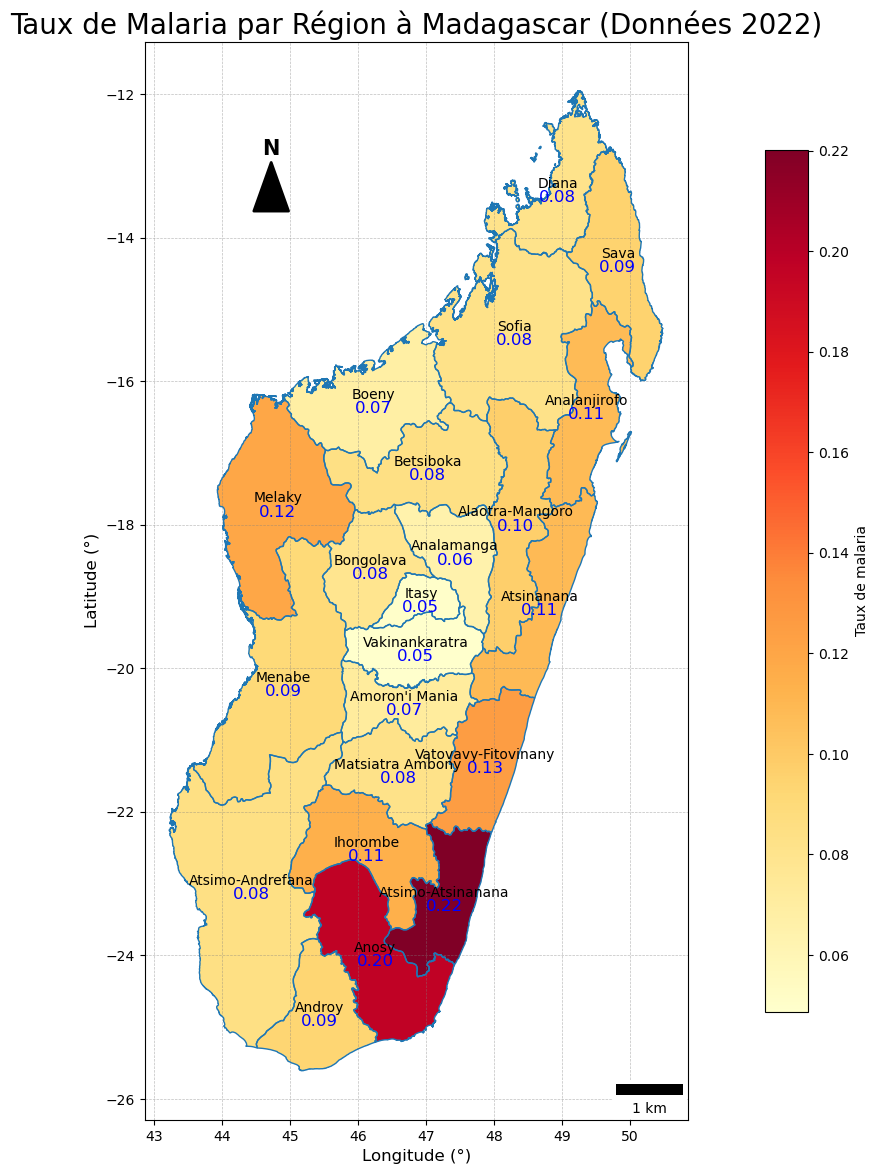

In [59]:
# REPRESENTATION GEOGRAPHIQUE POUR LA VISUALISATION

import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np  # Assurez-vous d'importer numpy pour la gestion des NaN

# Ignorer les avertissements liés à la géométrie en CRS géographique 
# Car pour les centroides on a utilisé le systeme en m et pour la graduation on utilise les dégrés 
# Et donc python nous signale des warning mais cela génere le resulatat voulu
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.*")

# Pour s'assurer que le GeoDataFrame est dans un CRS géographique (WGS 84)
shapefile1_geo = shapefile1.to_crs(epsg=4326)  

# Créeons la figure et l'axe
fig, ax = plt.subplots(1, 1, figsize=(20, 14))
shapefile1_geo.boundary.plot(ax=ax, linewidth=1)  # Pour tracer les frontières

# Créeons la carte avec un colormap
cmap = plt.cm.YlOrRd  # Juste pour stocker le code de couleur qui sera utilisée pour notre carte (ici on a opté pour YlOrRd qui va du jaune au rouge) 
shapefile1_geo.plot(column='Moyenne_Arithmétique_Taux_Paludisme_pond', # Colonne avec valeurs à visualiser
                    ax=ax, 
                    cmap=cmap, # Appliquer le code de couleur precedemment choisie
                    legend=True,
                    legend_kwds={'label': "Taux de malaria", 'orientation': "vertical", 'shrink': 0.8},
                    missing_kwds={'color': 'lightgrey', 'label': 'Aucune donnée'}) # Pour les données manquantes, seront en gris 
                                                            #(Mais dans notre cas on n'en aura pas car on les a exclu avant le calcul)

# Ajoutons les étiquettes avec le nom de la région et le taux au centre (d'où on a utilisé les centroid pour definir l'emplacement de ceux-ci)
for x, y, name, rate in zip(shapefile1_geo.geometry.centroid.x, 
                             shapefile1_geo.geometry.centroid.y, 
                             shapefile1_geo['shapeName'],
                             shapefile1_geo['Moyenne_Arithmétique_Taux_Paludisme_pond']):
# Affichons le nom de la région
    ax.text(x, y, name, fontsize=10, ha='center', va='bottom', color='black')  
                # ha=alignement hoizontal et on centre, de meme pour l'alignement vertical va
# Affichons le taux qui correspond à la region
    ax.text(x, y - 0.2, f"{rate:.2f}" if not np.isnan(rate) else "N/A", 
            fontsize=12, ha='center', va='bottom', color='blue')  

# Ajoutons une grille
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Pour le titre
ax.set_title('Taux de Malaria par Région à Madagascar (Données 2022)', fontdict={'fontsize': '20', 'fontweight': '3'})

# Etiquettes pour les axes
ax.set_xlabel('Longitude (°)', fontsize=12)  # Étiquette de l'axe X
ax.set_ylabel('Latitude (°)', fontsize=12)   # Étiquette de l'axe Y

############ DESSINONS MANUELLEMENT LA FLECHE DU NORD  ############
def fleche_nord(ax, x, y, size=1, compass_text="N", fontsize=12):
    # Dessin de la flèche du nord sur une carte.
    ax.annotate('', xy=(x, y + size), xytext=(x, y),
                arrowprops=dict(facecolor='black', edgecolor='black',
                                linewidth=2, headwidth=25, headlength=35, width=5))

    ax.annotate('', xy=(x, y), xytext=(x, y - size * 0.2),
                arrowprops=dict(facecolor='black', edgecolor='black',
                                linewidth=1, headwidth=0, headlength=0, width=1))

    ax.text(x, y + size + 0.05, compass_text, ha='center', va='bottom', fontsize=fontsize, fontweight='bold')

# Adapter aux coordonnées de l'image (positions basées sur la carte de Madagascar)
longitude_min = shapefile1_geo.total_bounds[0]
longitude_max = shapefile1_geo.total_bounds[2]
latitude_min = shapefile1_geo.total_bounds[1]
latitude_max = shapefile1_geo.total_bounds[3]
# Placer la boussole légèrement au sud-est de la carte
fleche_nord(ax, longitude_min + 1.5, latitude_max - 1.5, size=0.5, fontsize=15)
########################################################################

# Ajout de la barre d'échelle 
Echelle = ScaleBar(1, units='km', location='lower right') ## REVOIR VRAIMENT SI CE CALCUL EST BIEN FAIT
ax.add_artist(Echelle)

plt.show()

In [60]:
# POUR LE NIVEAU PROVINCE : Reprise des codes precedents en utilisant cette fois ci ADM2
from rasterstats import zonal_stats

# Chargeons le shapefile où on effectuera les calculs par defaut (ici c'est sur les regions)
shapefile2 = gpd.read_file('DONNEES MADAGASCAR/ADM2/geoBoundaries-MDG-ADM2.shp')

# Chemin vers le fichier .tiff
tiff_file = 'DONNEES RASTER/202406_Global_Pf_Parasite_Rate_MDG_2022.tiff'

# Pour obtenir les valeurs de pixels par zone sans utiliser 'stats' pour récupérer toutes les valeurs de pixels
zonal_statistiques2 = zonal_stats(
    shapefile2, tiff_file, stats=None, nodata=-9999, raster_out=True, all_touched=True
)

# Calculons de la moyenne arithmétique pour chaque zone et ajout des résultats
arith_moyenne_valeur = [] # Pour stocker les valeurs des moyennes arithmétiques 
for stat in zonal_statistiques2:
    # Récupérons les valeurs de pixels dans stat qu'on a defini precedemment
    valeur_pixel = stat['mini_raster_array']
    
    # Appliquons un masque pour exclure les valeurs manquantes ou négatives 
    # on prend les non NA et valeurs positives car il s'agit du taux de paludisme et donc ne peut pas être négatif
    valeurs_valides = valeur_pixel[(valeur_pixel >= 0) & (~np.isnan(valeur_pixel))]
    
    # Calculons la moyenne arithmétique si des valeurs positives existent
    arith_moy = np.mean(valeurs_valides) if len(valeurs_valides) > 0 else np.nan
    arith_moyenne_valeur.append(arith_moy)

# Ajoutons les résultats au GeoDataFrame
shapefile2['Moyenne_Arithmétique_Taux_Paludisme'] = arith_moyenne_valeur

# Affichons les résultats
print(shapefile2[['shapeName', 'Moyenne_Arithmétique_Taux_Paludisme']]) 

              shapeName  Moyenne_Arithmétique_Taux_Paludisme
0    1er Arrondissement                             0.053582
1     2e Arrondissement                             0.052922
2     3e Arrondissement                             0.051485
3     4e Arrondissement                             0.054359
4     5e Arrondissement                             0.053454
..                  ...                                  ...
114             Ambanja                             0.075281
115            Antalaha                             0.094725
116             Sambava                             0.104686
117              Andapa                             0.102199
118             Vohemar                             0.074919

[119 rows x 2 columns]


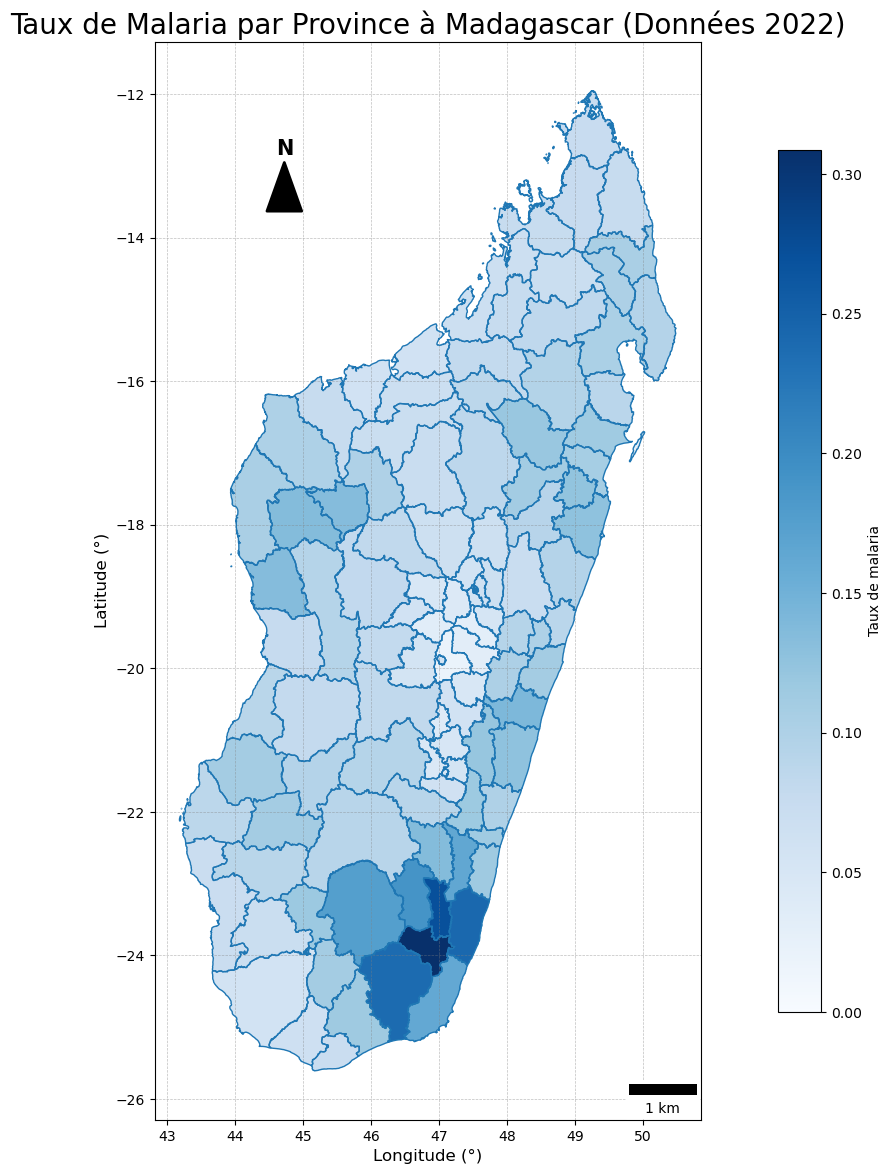

In [61]:
# VISUALISATION SANS LES LABELS (car trop nombreux) ET AU NIVEAU PROVINCE
# On reprend les codes pour la visualisation precedentes et on adapte pour le niveau province
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
from matplotlib_scalebar.scalebar import ScaleBar

# Pour ignorer les avertissements liés à la géométrie en CRS géographique
warnings.filterwarnings("ignore", category=UserWarning, message="Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.*")

# Assurons-nous que le GeoDataFrame est dans un CRS géographique (WGS 84)
shapefile2_geo = shapefile2.to_crs(epsg=4326)  # WGS 84

# Créeons la figure et l'axe
fig, ax = plt.subplots(1, 1, figsize=(20, 14))
shapefile2_geo.boundary.plot(ax=ax, linewidth=1)  # Tracer les frontières

# Créeons la carte avec un colormap
cmap = plt.cm.Blues  # Couleurs
shapefile2_geo.plot(column='Moyenne_Arithmétique_Taux_Paludisme', ax=ax, cmap=cmap, legend=True,
                    legend_kwds={'label': "Taux de malaria", 'orientation': "vertical", 'shrink': 0.8},
                    missing_kwds={'color': 'lightgrey', 'label': 'Aucune donnée'})

# Ajoutons une grille
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Personnalisation de la visualisation (Titre, taille de polices ...)
ax.set_title('Taux de Malaria par Province à Madagascar (Données 2022)', fontdict={'fontsize': '20', 'fontweight': '3'})

# Définissons les étiquettes pour les axes
ax.set_xlabel('Longitude (°)', fontsize=12)  # Étiquette de l'axe X
ax.set_ylabel('Latitude (°)', fontsize=12)   # Étiquette de l'axe Y

#######################    DESSIN DE LA FLECHE DU NORD     #####################################
def fleche_nord(ax, x, y, size=1, compass_text="N", fontsize=12):
    # Dessin de la flèche du nord sur une carte.
    ax.annotate('', xy=(x, y + size), xytext=(x, y),
                arrowprops=dict(facecolor='black', edgecolor='black',
                                linewidth=2, headwidth=25, headlength=35, width=5))

    ax.annotate('', xy=(x, y), xytext=(x, y - size * 0.2),
                arrowprops=dict(facecolor='black', edgecolor='black',
                                linewidth=1, headwidth=0, headlength=0, width=1))

    ax.text(x, y + size + 0.05, compass_text, ha='center', va='bottom', fontsize=fontsize, fontweight='bold')

# Adapter aux coordonnées de l'image (positions basées sur la carte de Madagascar)
longitude_min = shapefile1_geo.total_bounds[0]
longitude_max = shapefile1_geo.total_bounds[2]
latitude_min = shapefile1_geo.total_bounds[1]
latitude_max = shapefile1_geo.total_bounds[3]
# Placer la boussole légèrement au sud-est de la carte
fleche_nord(ax, longitude_min + 1.5, latitude_max - 1.5, size=0.5, fontsize=15)
########################################################################

# Ajout de la barre d'échelle 

Echelle = ScaleBar(1, units='km', location='lower right')  # Ajustez l'unité et la position selon vos besoins
ax.add_artist(Echelle)

plt.show()

In [62]:
############################# GOING DEEPER  #############################
# PRESENTONS LES EVOLUTIONS POUR LES DIFFERENTES ANNEES AU NIVEAU REGION

import numpy as np
import geopandas as gpd
from rasterstats import zonal_stats

# Chargeons le shapefile correspondant aux regions
shapefile1 = gpd.read_file('DONNEES MADAGASCAR/ADM1/geoBoundaries-MDG-ADM1.shp')

# Liste des années: nos données vont de 2000 à 2003 mais n'oublions par que dans le range, la derniere valeur n'est pas prise et donc on prendre de 2000 à 2023
years = range(2000, 2023)

# Créeons un dictionnaire pour stocker les résultats
stats_annuels = {}
    
# Calculons les statistiques et ceci suivant chaque année
for year in years:
    tiff_file = f'DONNEES RASTER/202406_Global_Pf_Parasite_Rate_MDG_{year}.tiff'
    # On va encore utiliser la fonction zonal_stat utilisée precedemment
    zonal_stats_result = zonal_stats(
        shapefile1, tiff_file, stats=None, nodata=-9999, raster_out=True, all_touched=True
    )
    
    arith_moyenne_valeur = []
    for stat in zonal_stats_result:
        valeur_pixel = stat['mini_raster_array']
        valeurs_valides = valeur_pixel[(valeur_pixel >= 0) & (~np.isnan(valeur_pixel))]
        arith_moy = np.mean(valeurs_valides) if len(valeurs_valides) > 0 else np.nan
        arith_moyenne_valeur.append(arith_moy)

    # Stockons les résultats pour chaque année
    stats_annuels[year] = arith_moyenne_valeur

# Convertissons le dictionnaire en DataFrame pour faciliter l'accès
import pandas as pd
results_df = pd.DataFrame(stats_annuels)
results_df['shapeName'] = shapefile1['shapeName']

# Affichons les résultats
print(results_df)


        2000      2001      2002      2003      2004      2005      2006  \
0   0.310940  0.303762  0.249494  0.220695  0.194109  0.180414  0.159402   
1   0.404763  0.383189  0.315289  0.283233  0.253955  0.243912  0.225389   
2   0.486555  0.461054  0.379862  0.341696  0.304550  0.293650  0.271394   
3   0.130412  0.137798  0.120411  0.115864  0.114873  0.119626  0.118055   
4   0.150824  0.143431  0.122021  0.118457  0.117410  0.117320  0.108636   
5   0.250163  0.249556  0.215372  0.209141  0.205966  0.204967  0.185940   
6   0.331644  0.337005  0.281931  0.251169  0.221227  0.208178  0.189220   
7   0.115964  0.138149  0.130130  0.129785  0.126094  0.126079  0.117181   
8   0.226673  0.251811  0.254161  0.296576  0.333685  0.358682  0.336810   
9   0.169377  0.183474  0.181602  0.208481  0.236042  0.251957  0.229523   
10  0.386715  0.369258  0.293135  0.247242  0.208671  0.193508  0.176905   
11  0.285614  0.270907  0.220647  0.199374  0.180650  0.170865  0.150276   
12  0.233627

In [63]:
# Pour exporter les resultats 

import pandas as pd
# Sélection des colonnes à exporter
export = shapefile1_geo[['shapeName', 'Moyenne_Arithmétique_Taux_Paludisme_pond']]

# Exportons vers un fichier Excel
export.to_excel("PALUDISME_PALU.xlsx", index=False)
